# 3D recon with KP matching

In [9]:
import cv2
import numpy as np 
import stereo_setting as stset

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

### Global variables

In [10]:
grid_sz = 100
n_matches = 1000 
list_kp1 = []
list_kp2 = []
dense_kp1 = None
dense_kp2 = None

calib_dir = "./basler_calib_params_2020/"

# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()

# create Brute-Force Matcher object
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

### Point matching

In [11]:
def kp_matching(rect_l, rect_r):
    # Find the keypoints and descriptors
    kp1, des1 = sift.detectAndCompute(rect_l, None)
    kp2, des2 = sift.detectAndCompute(rect_r, None)
    
    # Match descriptors
    matches = bf.match(des1, des2)
    
    # Sort them in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)
    
    # Extract kpt locations from matched pts
    list_kp1 = np.asarray([kp1[mat.queryIdx].pt for mat in matches[:n_matches]])
    list_kp2 = np.asarray([kp2[mat.trainIdx].pt for mat in matches[:n_matches]])
    
    # Calculate the transformation matrix
    trans_mat = list_kp1 - list_kp2
    
    # Return image with drawn matches
    img_kps = cv2.drawMatches(rect_l, kp1, rect_r, kp2, matches[:n_matches], None, flags=2)
    vert, hori = img_kps.shape[:2]
    resize_scale = 3
    scaled = (int(hori/resize_scale), int(vert/resize_scale))
    img_kps = cv2.resize(img_kps, scaled)
    
    return list_kp1, list_kp2, img_kps, trans_mat
#enddef

### Rectifying images

In [12]:
def rectify_images(orig_l, orig_r, calib_dir):
    vert, hori = orig_l.shape[:2]
    left_stereo_map, right_stereo_map, _ = stset.st_maps(calib_dir, (hori, vert))
    rect_l, rect_r = stset.st_rectify(orig_l, orig_r, left_stereo_map, right_stereo_map)
    
    return rect_l, rect_r
#enddef

### Helper functions

In [13]:
def rounding_list(a):
    np_a = np.array(a)
    np_a = np.around(np_a, decimals=0)
    np_b = np_a.astype(int)
    return np_b
#enddef

### Disparity from KP

In [14]:
def calculateDisparityFromKP(list_kp1, list_kp2, dimen):
    disp_image = np.zeros((dimen[1], dimen[0]))
    np_kp1, np_kp2 = rounding_list(list_kp1), rounding_list(list_kp2)
    trans_mat = np_kp1 - np_kp2
    
    for kp in np_kp1:
        disp_image[kp[0]][kp[1]] = 255.0
    #next
    
    return disp_image
#enddef
            

### Main code

In [18]:
orig_l_dir = "./singlerun_2020/20_L_.png"
orig_r_dir = "./singlerun_2020/20_R_.png"
    
orig_l, orig_r = cv2.imread(orig_l_dir), cv2.imread(orig_r_dir)
    
rect_l, rect_r = rectify_images(orig_l, orig_r, calib_dir)
list_kp1, list_kp2, img_kps, trans_mat = kp_matching(rect_l, rect_r)
    
vert, hori = rect_l.shape[:2]
resize_scale = 3
scaled = (int(hori/resize_scale), int(vert/resize_scale))
    
#     print(trans_mat)
    
x_delta = int(np.floor(np.abs(np.mean(trans_mat[:,0]))))
y_delta = int(np.floor(np.abs(np.mean(trans_mat[:,1]))))
    
disp = calculateDisparityFromKP(list_kp1, list_kp2, (vert, hori))
    
cv2.imshow("disp", cv2.resize(disp, scaled))
cv2.imshow("rect_l", cv2.resize(rect_l, scaled))
cv2.imshow("img_kps", img_kps)
cv2.waitKey(0)
cv2.destroyAllWindows()
    
print(len(trans_mat))
#enddef

1000


In [19]:
a = [[533.8918457,577.56658936],[1106.21447754,917.39343262],[1233.07739258,960.89935303]]

np_a = np.array(a)
np_a = np.around(np_a, decimals=0)
np_b = np_a.astype(int)


print(np_b)

for i in a:
    print(i[0])
    print(i[1])

[[ 534  578]
 [1106  917]
 [1233  961]]
533.8918457
577.56658936
1106.21447754
917.39343262
1233.07739258
960.89935303


In [20]:
RL = np.load(calib_dir+'RL.npy')
PL = np.load(calib_dir+'PL.npy')
RR = np.load(calib_dir+'RR.npy')
PR = np.load(calib_dir+'PR.npy')

T = np.load(calib_dir+'T.npy')

print("PL => \n", PL,
      "\n\nPR => \n", PR, 
      "\n\nRL => \n", RL, 
      "\n\nRR => \n", RR, 
      "\n\nT => \n", T)

PL => 
 [[9.71794410e+02 0.00000000e+00 1.08257719e+03 0.00000000e+00]
 [0.00000000e+00 9.71794410e+02 6.12736588e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]] 

PR => 
 [[ 9.71794410e+02  0.00000000e+00  1.08257719e+03 -2.33806338e+05]
 [ 0.00000000e+00  9.71794410e+02  6.12736588e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]] 

RL => 
 [[ 9.95221745e-01 -4.43267000e-04 -9.76395502e-02]
 [ 2.37756828e-03  9.99803204e-01  1.96951736e-02]
 [ 9.76116049e-02 -1.98332097e-02  9.95026944e-01]] 

RR => 
 [[ 0.99196667  0.00416646 -0.12643091]
 [-0.00670116  0.99978487 -0.0196294 ]
 [ 0.12632192  0.02031895  0.99178118]] 

T => 
 [[-238.65962912]
 [  -1.00241915]
 [  30.41831402]]


In [22]:
list_kp1.T

array([[ 533.8918457 , 1106.21447754, 1233.07739258, ..., 1371.19543457,
         568.0489502 ,  651.8394165 ],
       [ 577.56658936,  917.39343262,  960.89935303, ..., 1137.79309082,
         522.08148193,  532.97369385]])

In [ ]:
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    #verts, colors = filter_infinity(verts, colors)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')
#enddef

In [83]:
X = cv2.triangulatePoints(PL, PR, list_kp1.T, list_kp2.T)
# Remember to divide out the 4th row. Make it homogeneous
Y = (X/X[3])[:3]
x, y, z = Y[0], Y[1], Y[2]

Y[1]

array([ 932.44033036, 1007.20761675, 1022.12608379, 1043.95657562,
       1026.42902434, 1021.59572173, 1030.90183333, 1025.86603824,
        940.08496026,  997.01980406, 1033.15295329, 1017.80255501,
       1020.89314234, 1030.31469762, 1008.67433174, 1026.14028678,
       1032.50639813, 1035.76535446,  935.80047579, 1024.286029  ,
       1040.26848738,  962.54735422,  934.02679776, 1017.80255501,
        990.3304516 , 1004.40481365, 1032.10753057, 1018.7131548 ,
       1032.4480637 ,  986.01078403, 1021.59572173, 1025.10213133,
       1013.7120651 , 1022.62471702, 1027.75569221, 1043.85385272,
        998.76252197, 1019.55893013, 1004.55702307, 1024.34365824,
        934.02679776,  992.62769483, 1039.13018978, 1028.99302521,
       1033.60433944, 1023.5977676 , 1030.28187148, 1033.83117248,
        998.02953127, 1015.26189625, 1015.31193812, 1025.23387545,
       1017.79900838, 1028.79965214, 1016.6637436 , 1018.07060764,
       1011.34555476, 1009.89154027, 1013.7120651 , 1033.53144

<IPython.core.display.Javascript object>


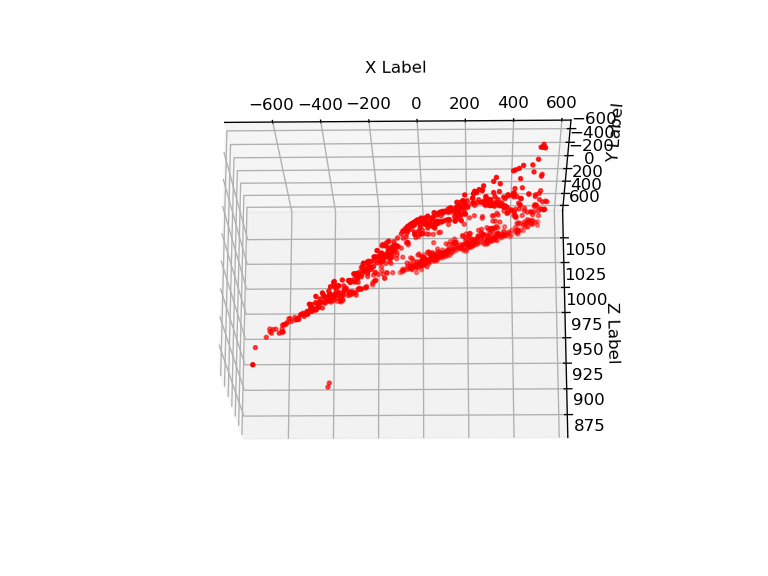

In [82]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c='r', marker='o', s=5)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.show()

<IPython.core.display.Javascript object>


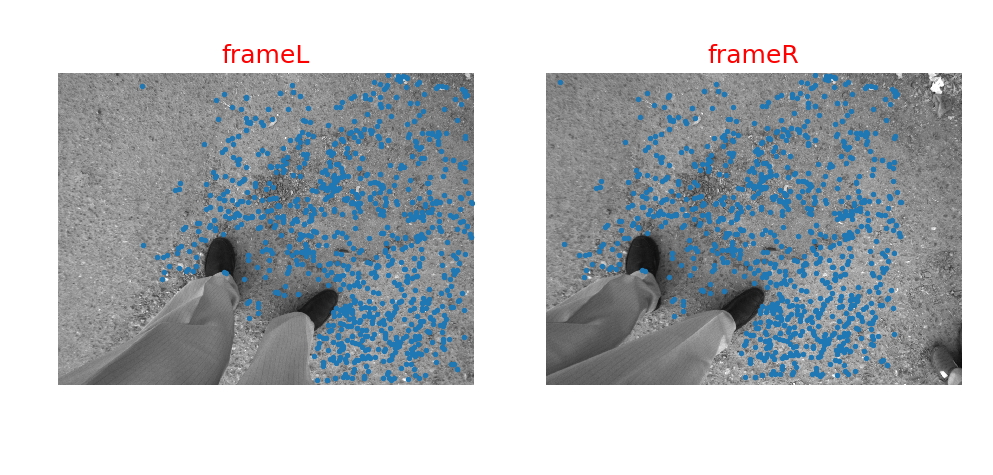

In [55]:
# x, y = zip(*list_kp1)
# plt.scatter(*zip(*list_kp1), s=5)
# plt.imshow(rect_l)
# plt.show

imgs = []
imgs.append(cv2.cvtColor(rect_l, cv2.COLOR_BGR2RGB))
imgs.append(cv2.cvtColor(rect_r, cv2.COLOR_BGR2RGB))

kp_lists = []
kp_lists.append(list_kp1)
kp_lists.append(list_kp2)

row,col = 1,2
f, axarr = plt.subplots(row,col,figsize=(8,5))
f.tight_layout()

axarr[0].imshow(imgs[0]),axarr[0].set_title('frameL', color='r', size=15), axarr[0].axis('off'), axarr[0].scatter(*zip(*kp_lists[0]), s=5)
axarr[1].imshow(imgs[1]),axarr[1].set_title('frameR', color='r', size=15), axarr[1].axis('off'), axarr[1].scatter(*zip(*kp_lists[1]), s=5)

plt.show()